<a href="https://colab.research.google.com/github/lisasdi/route/blob/main/cdetectron2_id.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# detectron2

In [ ]:
!pip install pyyaml==5.1
# This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html


In [ ]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

1.9.0+cu102 True


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

#photo

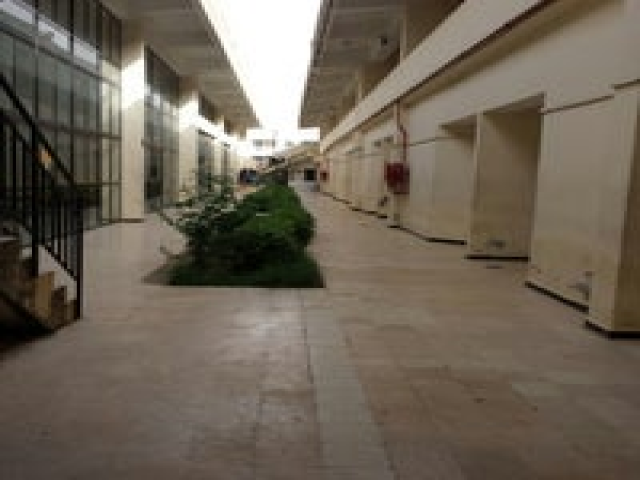

In [ ]:
!wget https://fastly.4sqi.net/img/general/200x200/32966021_CH-c7ig2hghbMDGX15p1kpNMaFv9EBsxFAok5ZPvqoM.jpg -q -O input.jpg
#!wget https://seha2020.usthb.dz/usthb%20photos/usthb5.JPG -q -O input.jpg
im= cv2.imread("./input.jpg")
im = cv2.resize(im, (640, 480), interpolation= cv2.INTER_AREA)
cv2_imshow(im)

In [ ]:
from google.colab import files 
import matplotlib.pyplot as pt
uploaded=files.upload()

Saving 2.jpg to 2.jpg


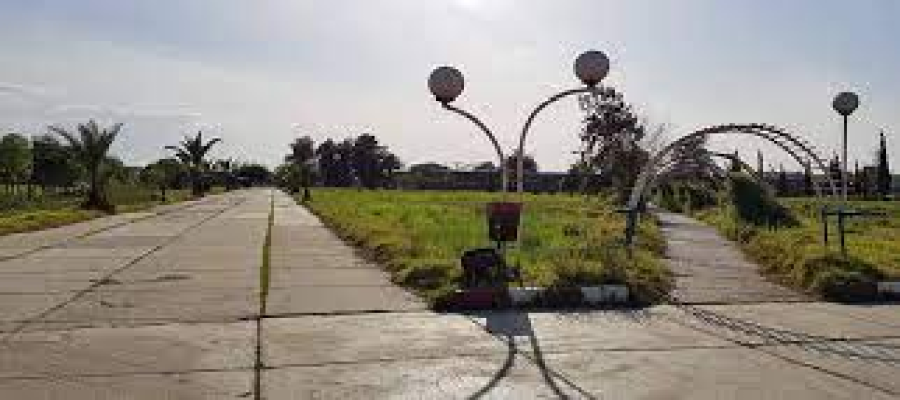

In [ ]:
im= cv2.imread("./2.jpg")
im = cv2.resize(im, (900, 400), interpolation= cv2.INTER_AREA)
#im = cv2.resize(im, (700, 400), interpolation= cv2.INTER_AREA)
cv2_imshow(im)


#fonctions 

In [ ]:
#tansformer les autres pixels en blanc
def transformerpixelsblanc(matrice):
   for i in range(0,matrice.shape[0]-1):
      for j in range(0,matrice.shape[1]-1):
          if matrice[i,j]!=0:
             matrice[i,j]=255

In [ ]:
#tansformer une photo en matrice
def imagetomatrice(image):
  numpydata = asarray(image) 
  #convertir image en  tableau NumPy
  np_img = numpy.array(image,dtype=np.uint8) 
  npf=np_img  
  return np_img

In [ ]:
#soustraction image et filtre gray
def soustragray(img1,img2):
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  imgs=img1-img2
  return imgs

In [ ]:
#Enlever le bruit 
def enleverbruit(image):
   kernel = None
   fgmask1 = cv2.erode(np_img, kernel, iterations = 2)
   fgmask = cv2.dilate(fgmask1, kernel, iterations = 25)
   cv2_imshow(fgmask1)
   return fgmask


In [ ]:
#squelette
def squelette(image):
  img = image
  size = np.size(img)
  skel = np.zeros(img.shape,np.uint8)
  ret,img = cv2.threshold(img,100,255,cv2.THRESH_BINARY)
  element = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
  done = False
  while( not done):
    eroded = cv2.erode(img,element)
    temp = cv2.dilate(eroded,element)
    temp = cv2.subtract(img,temp)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()

    zeros = size - cv2.countNonZero(img)
    if zeros==size:
        done = True
  return skel

In [ ]:
# sauvegarder les valeurs 
def sauvegarderVal(val,valR,liste,lister):
  if val not in liste:
    liste.append(val)
    lister.append(valR)

In [ ]:
def matriceclasse(mat,liste,listremplace):
  #on va utiiser deux méthodes

   setNumber=1
   for i in range (0,mat.shape[0]):
     for j in range (0,mat.shape[1]):

       if(mat[i,j]==255):
           if (mat[i-1,j] == 0) and (mat[i,j-1] == 0):
               mat[i,j] = setNumber
               setNumber= setNumber+1

           elif (mat[i-1,j] != 0) and (mat[i,j-1] == 0):
                mat[i,j] = mat[i-1,j]
           elif (mat[i-1,j] == 0) and (mat[i,j-1] != 0):
               mat[i,j] = mat[i,j-1]
           elif (mat[i-1,j] != 0) and (mat[i,j-1] != 0):
               if (mat[i-1,j] == mat[i,j-1]):
                  mat[i,j] = mat[i-1,j]
               elif (mat[i-1,j]>mat[i,j-1] and mat[i,j-1] != 0 ):
                  mat[i,j] =mat[i,j-1]
                  sauvegarderVal(mat[i-1,j],mat[i,j-1],liste,listremplace)
              
               else :
                  mat[i,j] = mat[i-1,j]
                  sauvegarderVal(mat[i,j-1],mat[i-1,j],liste,listremplace)


In [ ]:
# remplacer les valeur de liste par lister
def remplacedeVal(mat,liste,lister):
  k=0 
  while k< len(liste):
   x=liste[k]
   y=lister[k]
   for i in range (0,mat.shape[0]):
     for j in range (0,mat.shape[1]):
       if (mat[i,j]==x):
         mat[i,j]=y
   k=k+1


In [ ]:
#supprimer les valeurs en double
def valeurdouble(liste,lister):
   k=0
   
   while k< len(liste):
    x=liste[k]
    for i in range(0,len(lister)):
     if (lister[i]==x):
         lister[i]=lister[k]
    k=k+1
    

In [ ]:
#calculer nombre de régions
def calculregion(matrice,listeregion):
    for i in range(0,matrice.shape[0]):
         for j in range(0,matrice.shape[1]):
              if (matrice[i,j]!=0 and matrice[i,j]!=255 ):
                if matrice[i,j] not in listeregion:
                   listeregion.append(matrice[i,j])

       

In [ ]:
#calculer nb pixels pour chaque classe
def nombrepixelsclasse(matrice,nb):
  nombre=0
  for i in range(0,matrice.shape[0]):
         for j in range(0,matrice.shape[1]):
           if (matrice[i,j]==nb ):
             nombre=nombre+1
  return nombre


In [ ]:
# donner une couleur pour chaque classe (verification)
def couleurclasse(matrice,nb):
  for i in range(0,matrice.shape[0]):
         for j in range(0,matrice.shape[1]):
           if (matrice[i,j]==nb ):
              matrice[i,j]=255


In [ ]:
#claculer et sauvegarder le nb de pixels pour chaque classe
def nbpixelsclasse(matrice,listeclasse):
   k=0
   listenew=[]
   while k< len(listeclasse):
     x=listeclasse[k]
     listenew.append(nombrepixelsclasse(matrice,x))
     k=k+1
   return listenew

In [ ]:
def calculer_nb_id(matrice,id):
  nb=0
  for i in range(0,matrice.shape[0]-1):
     for j in range(0,matrice.shape[1]-1):
         if matrice[i,j]==id:
             nb=nb+1
  return nb 

In [ ]:
def i_j_moitie_nbid(matrice,id,x,y):
  n=0
  k=calculer_nb_id(matrice,id)

  k=(k//2)
  
  for i in range(0,matrice.shape[0]-1):
     for j in range(0,matrice.shape[1]-1):
       
       if matrice[i,j]==id and n==k:
            x.append(i)
            
            y.append(j)
            
            return x,y
            
       if matrice[i,j]==id:
             n=n+1

In [ ]:
# sauvegarder les valeuri et j de listeclasse dans 2 liste x et y
def sauvij(mat,liste,x,y):
  k=0 
  while k< len(liste):
   n=liste[k]
   
   for i in range (0,mat.shape[0]):
     for j in range (0,mat.shape[1]):
       if (mat[i,j]==n):
            x.append(i)
            y.append(j)
   k=k+1
  return x,y

In [ ]:
# remplacer les valeur de liste par min
def remplacedeVal_int(mat,liste,min):
  k=0 
  while k< len(liste):
   x=liste[k]
   for i in range (0,mat.shape[0]):
     for j in range (0,mat.shape[1]):
       if (mat[i,j]==x):
         mat[i,j]=min
   k=k+1


In [ ]:
# sauvegarder les valeuri et j de listeclasse dans 2 liste x et y
def sauvij_id(mat,id,x,y):

   for i in range (0,mat.shape[0]):
     for j in range (0,mat.shape[1]):
       if (mat[i,j]==id):
            x.append(i)
            y.append(j)
   return x,y

In [ ]:
#trouver les id appart

def id_intersect(listeregion,xint,yint,mat):
     liste_id_appart=[]
     i=0
     while i< len(listeregion):
        xid=[]
        yid=[]
        trouve=False
        id=listeregion[i]
        sauvij_id(mat,id,xid,yid)
        k=0
        while k< len(xid) and trouve==False:
            for j in range(0,len(xint)):

                  if (xid[k]==int(xint[j]) and yid[k]==int(yint[j])):
                      trouve=True
                      if id not in liste_id_appart:
                        liste_id_appart.append(id)

            k=k+1
        i=i+1

     return liste_id_appart

In [ ]:
def minimum_id(listeid):
  min=0
  if len(listeid)>0:
    k=0
    min=listeid[k]
    k=k+1
    while k<len(listeid):
        x=listeid[k]
        if (x<min):
          max=x
        k=k+1
  return min

#detection route

In [ ]:
cfg = get_cfg()

In [ ]:
# Object Detection
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_f6e8b1.pkl: 243MB [00:06, 40.6MB/s]                           


In [ ]:
# Object Detection Visualizer
predictions = predictor(im)["instances"]
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(predictions.to("cpu"))


In [ ]:
# Panoptic Segmentation
# Ref: https://youtu.be/Pb3opEFP94U
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_cafdb1.pkl: 261MB [00:06, 38.5MB/s]                           


##Tout detecter sauf 'pavement ,road,personne,car'
***personne et car ***: detectron2 ne leurs donne pas **une couleur unique** ,donc lors de la soustraction des deux photos on aura dans le résultat **car and personne**.
Pour pouvoir les éliminer, on ne les détecte pas dans les deux images(ça serait des objets en communs)

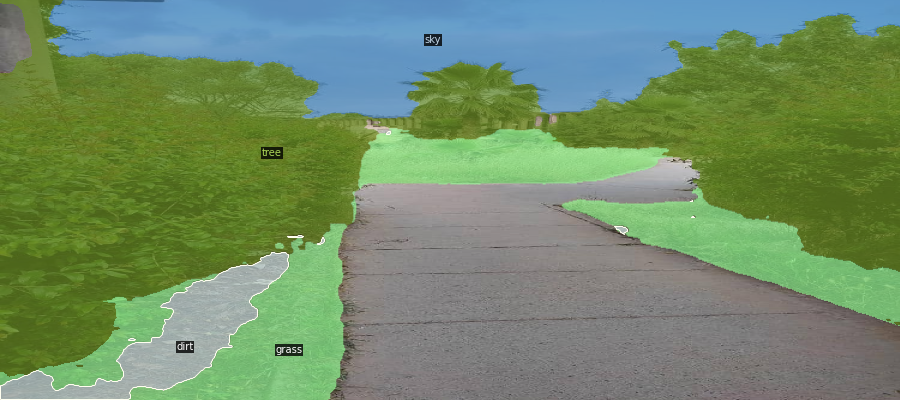

In [ ]:
# Panoptic Segmentation Visualizer
# We can use `Visualizer` to draw the predictions on the image.
predictions, segmentInfo = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
# Uncomment to filter out specific segments
out = v.draw_panoptic_seg_predictions(predictions.to("cpu"), list(filter(lambda x: x['category_id'] != 21 and x['category_id'] != 44 and x['category_id'] != 0 and x['category_id'] != 2 and x['category_id'] != 1, segmentInfo)), area_threshold=.1)
cv2_imshow(out.get_image()[:, :, ::-1])

##Tout detecter sauf 'personne,car'

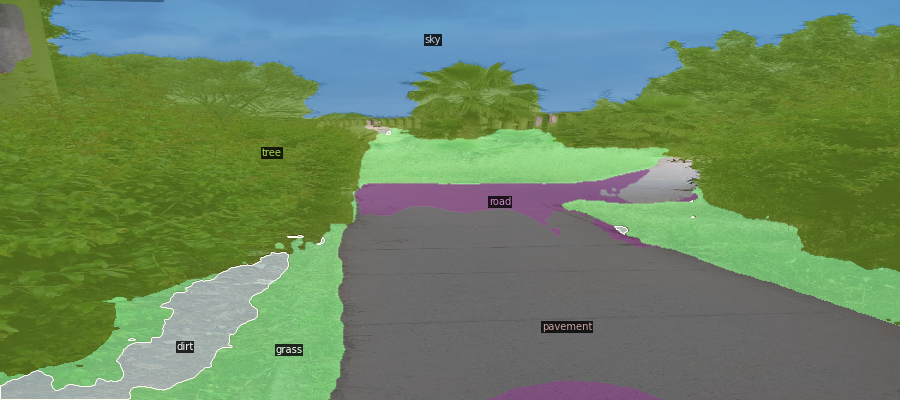

In [ ]:
predictions, segmentInfo = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
out2 = v.draw_panoptic_seg_predictions(predictions.to("cpu"), list(filter(lambda x:  x['category_id'] != 0 and x['category_id'] != 2 and x['category_id'] != 1, segmentInfo)), area_threshold=.1)
cv2_imshow(out2.get_image()[:, :, ::-1])

##soustraction des deux images
pour obtenir que la partie de la route

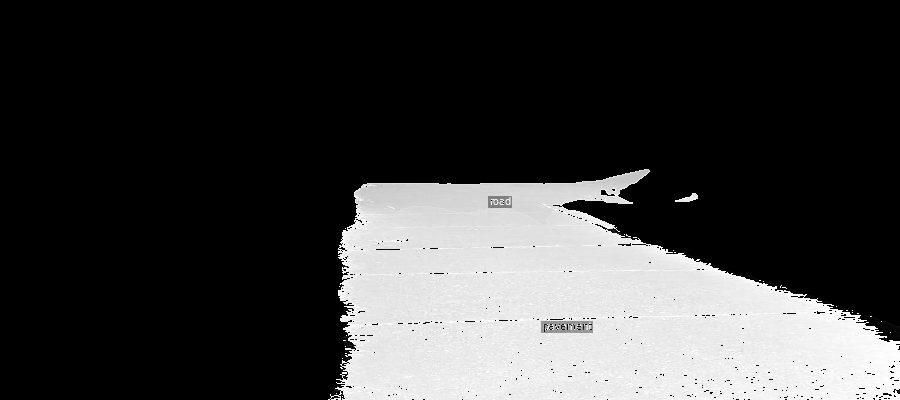

In [ ]:

gray = soustragray(out2.get_image(),out.get_image())
#gray=out1.get_image()-out.get_image()
cv2_imshow(gray)


##image to matrice

In [ ]:
from numpy import asarray 
from PIL import Image 
import numpy 

#convertir image en  tableau NumPy
np_img =imagetomatrice(gray)

##changer les pixels qui restent en blanc

In [ ]:
transformerpixelsblanc(np_img)

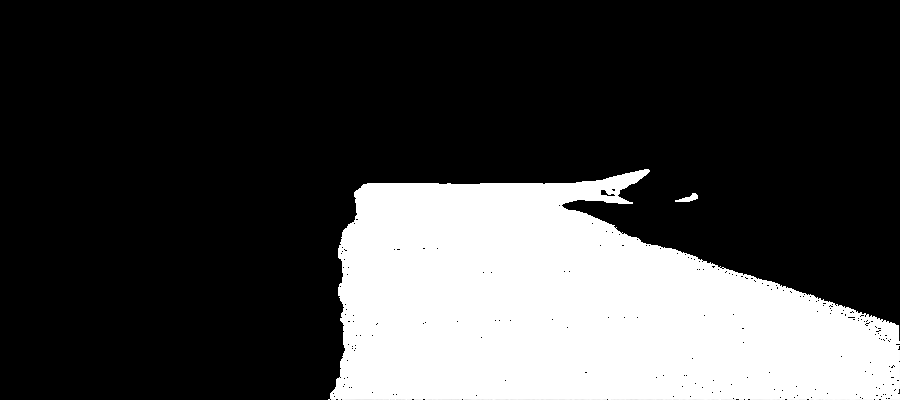

In [ ]:
cv2_imshow(np_img)
affRoute=np_img

##partie squelette

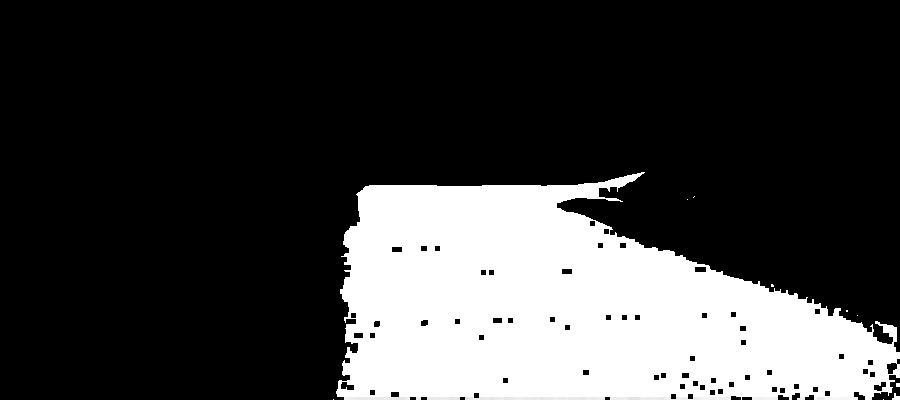

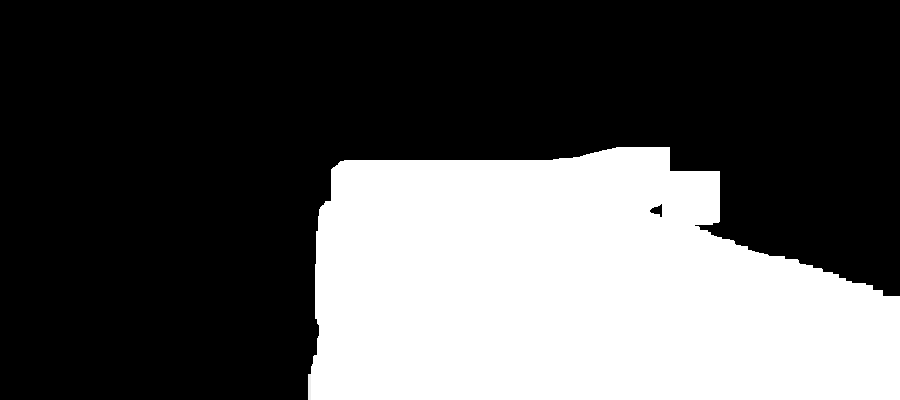

In [ ]:
 # Apply some morphological operations to make sure you have a good mask
fgmask = enleverbruit(np_img)
cv2_imshow(fgmask)


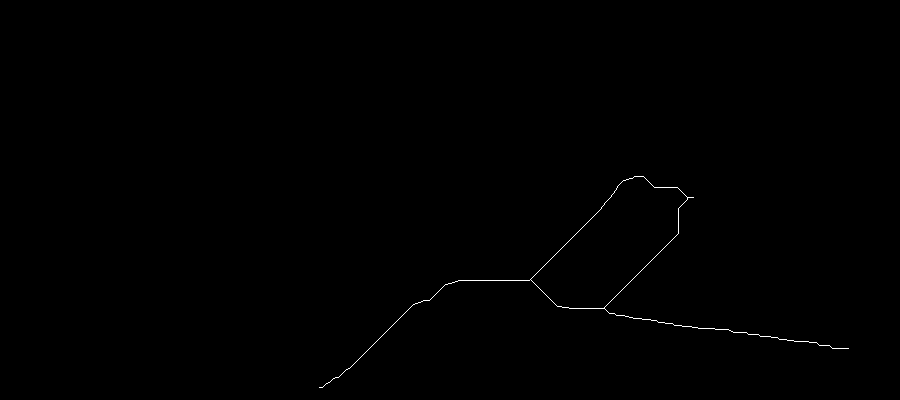

In [ ]:
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize



skeleton_lee = skeletonize(fgmask, method='lee')
cv2_imshow(skeleton_lee)

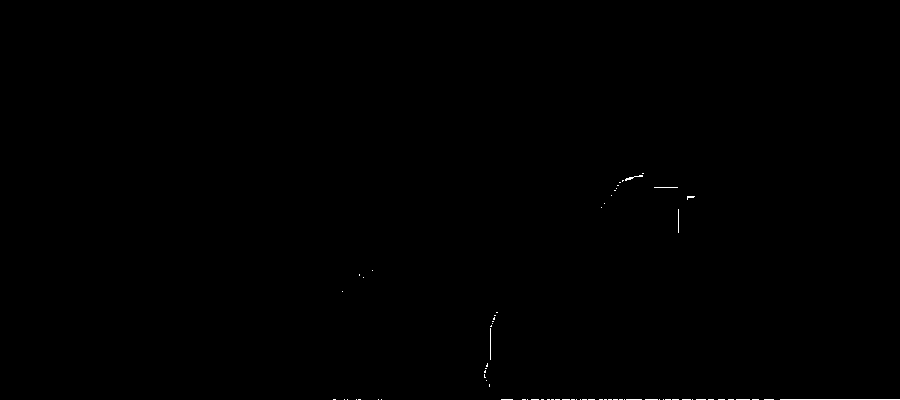

In [ ]:
#squelette
skel=squelette(fgmask)
cv2_imshow(skel)
affSquelette=skel

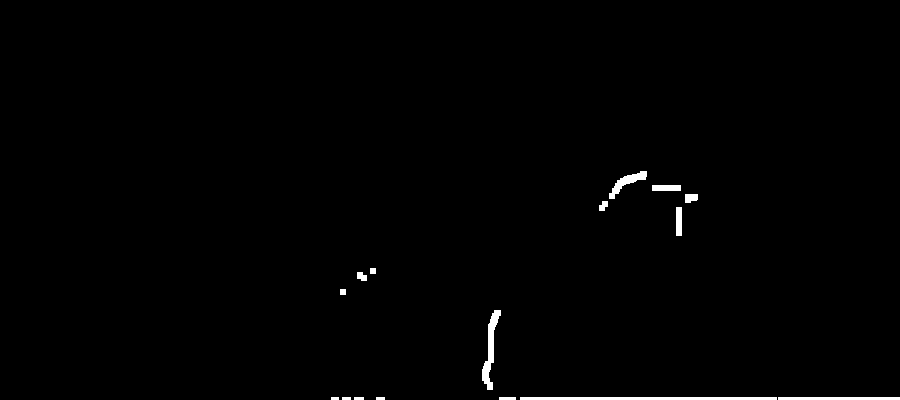

In [ ]:
#traitement
#skel=thin
kernel = np.ones((6, 6), np.uint8) 
d_im = cv2.dilate(skel, kernel, iterations=1)
cv2_imshow(d_im)

400 x 900
2 dimensions



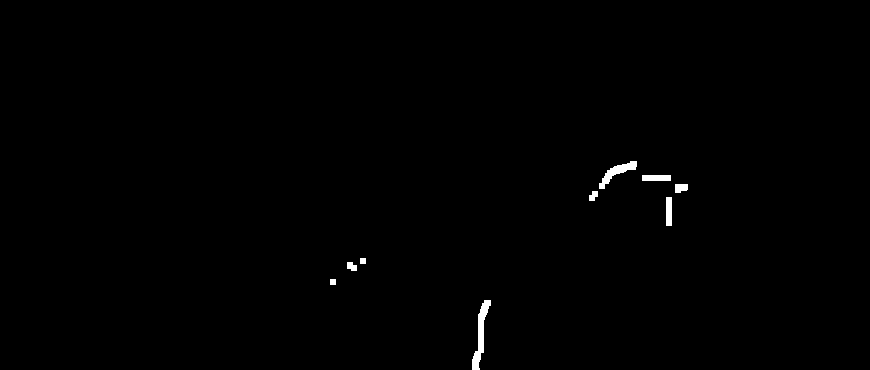

In [ ]:
#couper la  photo
matriceImageNG = np.array(d_im)
lignes, colonnes = matriceImageNG.shape
print(lignes, "x", colonnes)
print(matriceImageNG.ndim, "dimensions")
print("")
imgcrop=matriceImageNG [10:lignes-20,10:colonnes-20]
cv2_imshow(imgcrop)
d_im=imgcrop

## Code qui elimine un peu

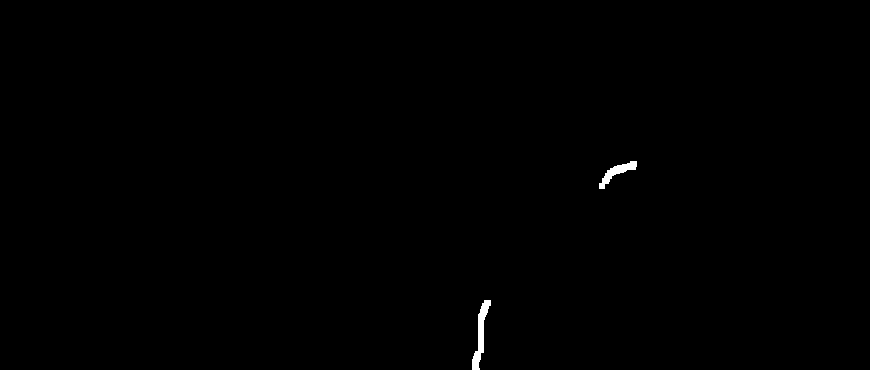

In [ ]:
#find all your connected components (white blobs in your image)
img=d_im
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
#connectedComponentswithStats yields every seperated component with information on each of them, such as size
#the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
sizes = stats[1:, -1]; nb_components = nb_components - 1

# minimum size of particles we want to keep (number of pixels)
#here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
min_size = 200

#your answer image
img2 = np.zeros((output.shape))
#for every component in the image, you keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img2[output == i + 1] = 255
cv2_imshow(img2)
affSquelettetraitement=img2

<class 'numpy.ndarray'>
(370, 870)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


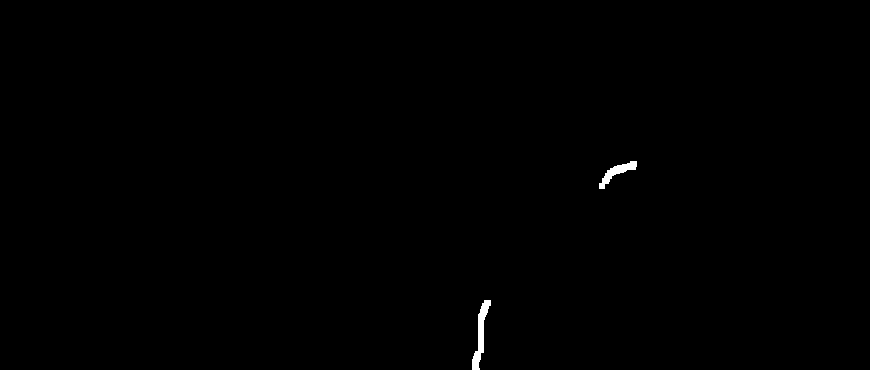

In [ ]:
from numpy import asarray 
from PIL import Image 
import numpy 
#
numpydata = asarray(img2) 
  
print(type(numpydata)) 
  
print(numpydata.shape)
#convertir image en  tableau NumPy
np_img = numpy.array(img2,dtype=np.uint8) 
npf=np_img  
print(np_img)
cv2_imshow(np_img)

## Traitement de notre matrice

In [ ]:
listef=[]
listefr=[]
matriceclasse(np_img,listef,listefr)
print(img2)
print(listef)
print(listefr)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21]


In [ ]:
valeurdouble(listef,listefr)
print(listef)
print(listefr)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 13, 13, 13, 13, 13, 13, 13, 13, 13]


In [ ]:
remplacedeVal(np_img,listef,listefr)

In [ ]:
listeregion=[]

calculregion(np_img,listeregion)
print(listeregion)



[1, 13]


In [ ]:
print(len(listeregion))
listeregionfinal=[]

2


## Recuperer X et Y

In [ ]:
x=[]
y=[]
for i in range(0,len(listeregion)):
   xy=i_j_moitie_nbid(np_img,listeregion[i],x,y)
print(x)
print(y)

[170, 333]
[622, 483]


In [ ]:
axex=[]
axey=[]
for i in range(0,len(listeregion)):
     sauvij(np_img,listeregion,axex,axey)
print(axex)
print(axey)

[161, 161, 161, 161, 161, 161, 161, 162, 162, 162, 162, 162, 162, 162, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 172, 172, 172, 172,

In [ ]:
print(np_img.shape[0])

370


## Regression lineaire

Estimated coefficients:
b_0 = 754.3315144198511  \ 
b_1 = -0.8149308713473219


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.7/dist-packages/shapely/geometry/linestring.py:46: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  ret = geos_linestring_from_py(coordinates)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


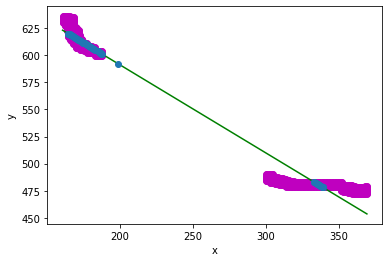

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
from shapely.geometry import LineString
  
def estimate_coef(x, y): 
    
    n = np.size(x) 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 
  
def plot_regression_line(x, y, b,xint,yint): 
    
    plt.scatter(x, y, color = "m", 
               marker = "o", s = 30) 
  
    
    y_pred = b[0] + b[1]*x 
  
    
    plt.plot(x, y_pred, color = "g") 
    #trouver les points d'intersections

    #meth2

    first_line = LineString(np.column_stack((x, y)))
    second_line = LineString(np.column_stack((x, y_pred)))
    intersection = first_line.intersection(second_line)

    if intersection.geom_type == 'MultiPoint':
          plt.plot(*LineString(intersection).xy, 'o')
          x, y = LineString(intersection).xy

    
    
    plt.xlabel('x') 
    plt.ylabel('y') 
    plt.show() 
    #return xint,y[idx]
    return x,y

  

if(len(listeregion)==0):
  print('refaire L image')
else: 
  xint=[]
  yint=[]
  x = np.array(axex) 
  y = np.array(axey) 
  
  b = estimate_coef(x, y) 
  print("Estimated coefficients:\nb_0 = {}  \ \nb_1 = {}".format(b[0], b[1])) 

   
  x,y=plot_regression_line(x, y, b,xint,yint) 



##new nb région

In [ ]:
listeid=id_intersect(listeregion,x,y,np_img)
print(listeid)

[1, 13]


In [ ]:
min=0
min=minimum_id(listeid)

In [ ]:
if min!=0:
   remplacedeVal_int(np_img,listeid,min)
listeregionnv=[]
calculregion(np_img,listeregionnv)
print(len(listeregionnv))

1


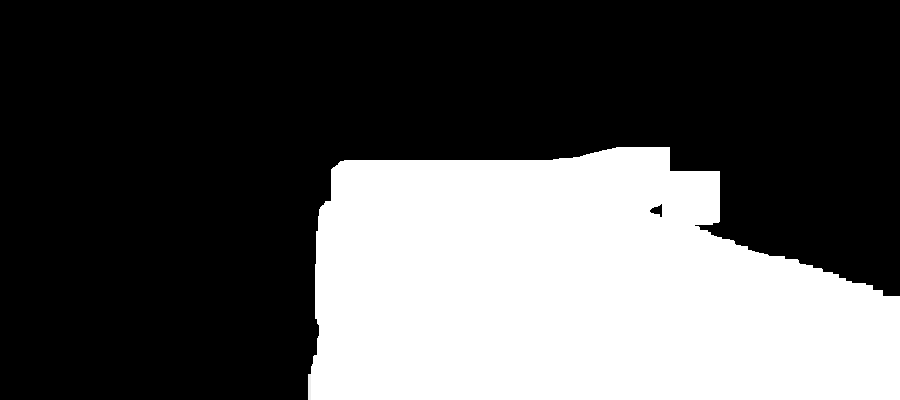

In [ ]:
#couleurclasse(np_img,1)

cv2_imshow(fgmask)

#Trouver le type 

##fonctions pour le type

In [ ]:
#récuperer les valeurs de i et j dans la matrice des pixels blancs
def calcul_couverture(np_img,listjaune,listnoir):

 np_imgnew=np_img

 for i in range(0,np_imgnew.shape[0]-1):
  for j in range(0,np_imgnew.shape[1]-1):
     if np_imgnew[i,j]==166:
       #jaune
       if np_imgnew[i-1,j-1]==255:
         listjaune=listjaune+1         
       elif np_imgnew[i-1,j]==255:
         listjaune=listjaune+1
       elif np_imgnew[i-1,j+1]==255:
         listjaune=listjaune+1
       elif np_imgnew[i,j-1]==255:
        listjaune=listjaune+1
       elif np_imgnew[i,j+1]==255:
         listjaune=listjaune+1
       elif np_imgnew[i+1,j-1]==255:
        listjaune=listjaune+1
       elif np_imgnew[i+1,j]==255:
         listjaune=listjaune+1
       elif np_imgnew[i+1,j+1]==255:
         listjaune=listjaune+1
         #noir
       if np_imgnew[i-1,j-1]==0:
         listnoir=listnoir+1         
       elif np_imgnew[i-1,j]==0:
          listnoir=listnoir+1 
       elif np_imgnew[i-1,j+1]==0:
         listnoir=listnoir+1 
       elif np_imgnew[i,j-1]==0:
         listnoir=listnoir+1 
       elif np_imgnew[i,j+1]==0:
          listnoir=listnoir+1 
       elif np_imgnew[i+1,j-1]==0:
         listnoir=listnoir+1 
       elif np_imgnew[i+1,j]==0:
          listnoir=listnoir+1 
       elif np_imgnew[i+1,j+1]==0:
          listnoir=listnoir+1 
 return listjaune,listnoir    

In [ ]:
listjaune=0
listnoir=0

jaune,noir=calcul_couverture(imageT,listjaune,listnoir)      
    
print('nb pixels blancs =',jaune)
print('nb pixels noirs =',noir)
nb=0
for i in range(0,imageT.shape[0]-1):
  for j in range(0,imageT.shape[1]-1):
     if imageT[i,j]==166:
       nb=nb+1
print('nb pixels des lignes dessinées en gris =',nb)



nb pixels blancs = 0
nb pixels noirs = 1060
nb pixels des lignes dessinées en gris = 1559


## V ou Droite
 Quand j'ai nbregions=1

In [ ]:
#recuperer les x et y
x=[]
y=[]
for i in range(0,len(listeregion)):
   xy=i_j_moitie_nbid(np_img,listeregion[i],x,y)
print(x)
print(y)

[254]
[384]


In [ ]:
x.append(np_img.shape[0]-20)
y.append(np_img.shape[1]//2)

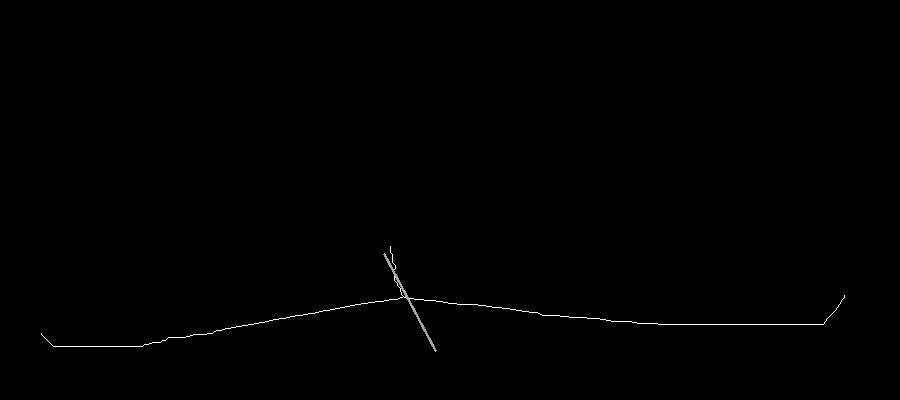

In [ ]:
#quand on a nb regions = 1 : droite ou V
#Droite
imageDr=skeleton_lee  
color = (	166, 46, 68) 
thickness = 2 
#1.  53, 337,408,351 ,350,450
start_point = (y[0], x[0])  
end_point = (y[1],x[1]) 
imageT = cv2.line(imageDr, start_point, end_point, color, thickness) 

cv2_imshow(imageDr)

In [ ]:
listjaune=0
listnoir=0

jaune,noir=calcul_couverture(imageT,listjaune,listnoir)      
    
print('nb pixels blancs =',jaune)
print('nb pixels noirs =',noir)
nb=0
for i in range(0,imageT.shape[0]-1):
  for j in range(0,imageT.shape[1]-1):
     if imageT[i,j]==166:
       nb=nb+1
print('nb pixels des lignes dessinées en gris =',nb)



nb pixels blancs = 19
nb pixels noirs = 269
nb pixels des lignes dessinées en gris = 272


In [ ]:
#recuperer les x et y
x=[]
y=[]
for i in range(0,len(listeregion)):
   xy=i_j_moitie_nbid(np_img,listeregion[i],x,y)
y.append(np_img.shape[1]-y[0])
x.append(x[0])
x.append(np_img.shape[0]-20)
y.append(np_img.shape[1]//2)

print(x)
print(y)


[254, 254, 350]
[384, 486, 435]


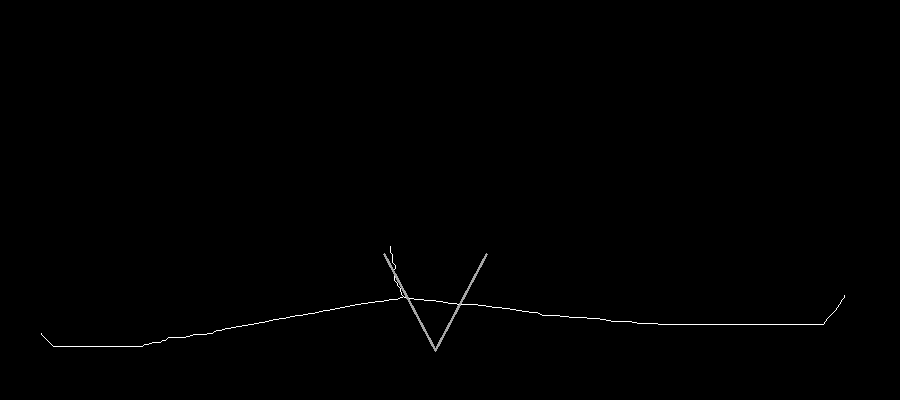

In [ ]:
#V
imageV=skeleton_lee  
color = (	166, 46, 68) 
thickness = 2 
#1.  53, 337,408,351 ,350,450
start_point = (y[0], x[0])  
end_point = (y[2],x[2]) 
imageV = cv2.line(imageV, start_point, end_point, color, thickness) 
#2

start_point1 = (y[1],x[1])  
end_point1 = (y[2],x[2])  
imageV = cv2.line(imageV, start_point1, end_point1, color, thickness) 
cv2_imshow(imageV)

In [ ]:
listjaune=0
listnoir=0

jaune,noir=calcul_couverture(imageV,listjaune,listnoir)      
    
print('nb pixels blancs =',jaune)
print('nb pixels noirs =',noir)
nb=0
for i in range(0,imageV.shape[0]-1):
  for j in range(0,imageV.shape[1]-1):
     if imageV[i,j]==166:
       nb=nb+1
print('nb pixels des lignes dessinées en gris =',nb)



nb pixels blancs = 27
nb pixels noirs = 534
nb pixels des lignes dessinées en gris = 538


##T /V/Y avec squelette2

In [ ]:
#recuperer les x et y
x=[]
y=[]
for i in range(0,len(listeregion)):
   xy=i_j_moitie_nbid(np_img,listeregion[i],x,y)
print(x)
print(y)

[279, 270]
[288, 806]


In [ ]:
x.append(np_img.shape[0]-20)
y.append(np_img.shape[1]//2)

In [ ]:
print(x)
print(y)

[279, 270, 350]
[288, 806, 435]


547.0
274.5


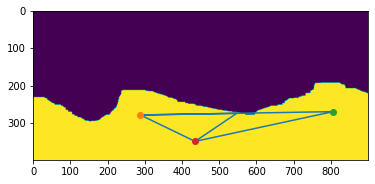

In [ ]:
from bokeh.plotting import figure, output_file, show 
import cv2
import matplotlib.pyplot as plt
import numpy as np



def Segments(x0 ,y0 ,x1 , y1,x2,y2):
  img=np_img
  x4=(x0+x1)/2
  print(x4)
  
  y4=(y0+y1)/2
  print(y4)
  x = np.array([x0, x1, x2,x0,x4,x2])
  y = np.array([y0, y1, y2,y0,y4,y2])
  plt.plot(x, y)
  #fixer des points 
  plt.plot(x0, y0,x1, y1, x2, y2, marker = 'o')
  plt.imshow(fgmask)
  il=plt.show()
  
  return plt.show()
x0=x[0]
y0=y[0]
x1=x[1]
y1=y[1]
x2=x[2]
y2=y[2]
Segments( y0,x0,y1,x1,y2,x2)

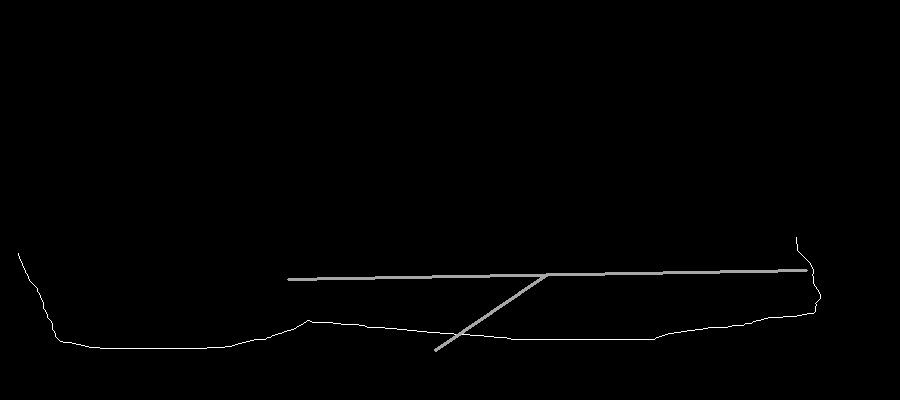

In [ ]:
#T
imageT=skeleton_lee  
color = (	166, 46, 68) 
thickness = 2 
#1.  53, 337,408,351 ,350,450
start_point = (y[0], x[0])  
end_point = (y[1],x[1]) 
imageT = cv2.line(imageT, start_point, end_point, color, thickness) 
#2
point1=(x[0]+x[1])//2
point2=(y[0]+y[1])//2
start_point1 = (point2,point1)  
end_point1 = (y[2],x[2])  
imageT = cv2.line(imageT, start_point1, end_point1, color, thickness) 
cv2_imshow(imageT)

In [ ]:
listjaune=0
listnoir=0

jaune,noir=calcul_couverture(imageT,listjaune,listnoir)      
    
print('nb pixels blancs =',jaune)
print('nb pixels noirs =',noir)
nb=0
for i in range(0,imageT.shape[0]-1):
  for j in range(0,imageT.shape[1]-1):
     if imageT[i,j]==166:
       nb=nb+1
print('nb pixels des lignes dessinées en gris =',nb)



nb pixels blancs = 7
nb pixels noirs = 1419
nb pixels des lignes dessinées en gris = 2002


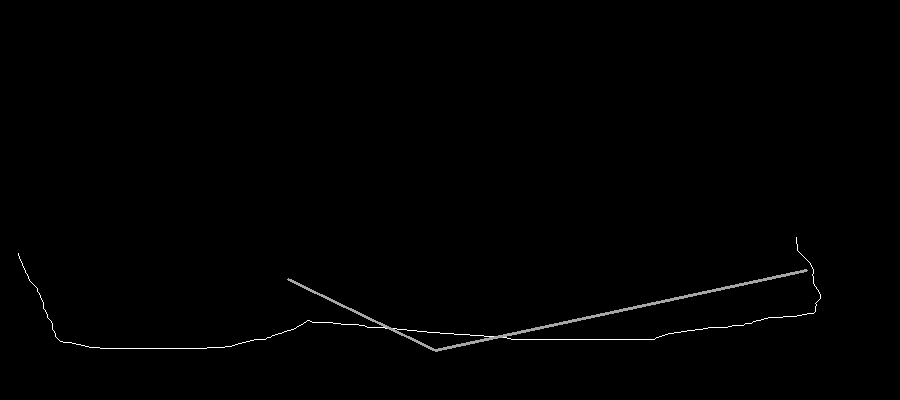

In [ ]:
#V
imageV=skeleton_lee  
color = (	166, 46, 68) 
thickness = 2 
#1.  53, 337,408,351 ,350,450
start_point = (y[0], x[0])  
end_point = (y[2],x[2]) 
imageV = cv2.line(imageV, start_point, end_point, color, thickness) 
#2

start_point1 = (y[1],x[1])  
end_point1 = (y[2],x[2])  
imageV = cv2.line(imageV, start_point1, end_point1, color, thickness) 
cv2_imshow(imageV)

nb pixels blancs = 25
nb pixels noirs = 1320
nb pixels des lignes dessinées en gris = 1529


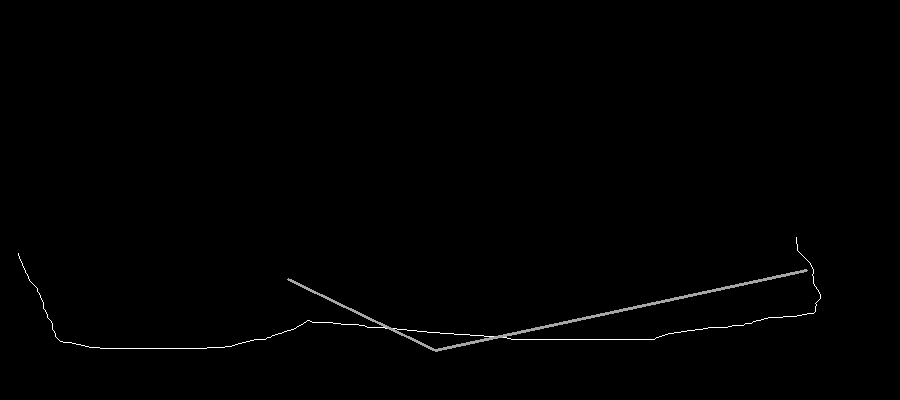

In [ ]:
#récuperer les valeurs de i et j dans la matrice des pixels blancs
listjaune=0
listnoir=0
jaune,noir=calcul_couverture(imageV,listjaune,listnoir)  
        
    
print('nb pixels blancs =',jaune)
print('nb pixels noirs =',noir)
nb=0
for i in range(0,imageV.shape[0]-1):
  for j in range(0,imageV.shape[1]-1):
     if imageV[i,j]==166:
       nb=nb+1
print('nb pixels des lignes dessinées en gris =',nb)


cv2_imshow(imageV)

##T /V/Y avec fgmask

In [ ]:
#recuperer les x et y
x=[]
y=[]
for i in range(0,len(listeregion)):
   xy=i_j_moitie_nbid(np_img,listeregion[i],x,y)
print(x)
print(y)

[279, 270]
[288, 806]


In [ ]:
x.append(np_img.shape[0]-20)
y.append(np_img.shape[1]//2)

In [ ]:
print(x)
print(y)

[279, 270, 350]
[288, 806, 435]


### T

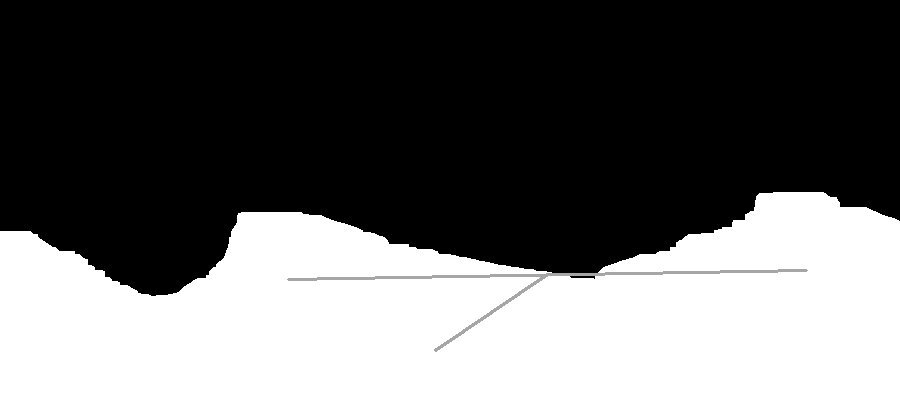

In [ ]:
#T
imageT=fgmask 
color = (	166, 46, 68) 
thickness = 2 
#1.  53, 337,408,351 ,350,450
start_point = (y[0], x[0])  
end_point = (y[1],x[1]) 
imageT = cv2.line(imageT, start_point, end_point, color, thickness) 
#2
point1=(x[0]+x[1])//2
point2=(y[0]+y[1])//2
start_point1 = (point2,point1)  
end_point1 = (y[2],x[2])  
imageT = cv2.line(imageT, start_point1, end_point1, color, thickness) 
cv2_imshow(imageT)

In [ ]:
listjaune=0
listnoir=0

jaune,noir=calcul_couverture(imageT,listjaune,listnoir)      
    
print('nb pixels blancs =',jaune)
print('nb pixels noirs =',noir)
nb=0
for i in range(0,imageT.shape[0]-1):
  for j in range(0,imageT.shape[1]-1):
     if imageT[i,j]==166:
       nb=nb+1
print('nb pixels des lignes dessinées en gris =',nb)



nb pixels blancs = 1355
nb pixels noirs = 75
nb pixels des lignes dessinées en gris = 2002


###V

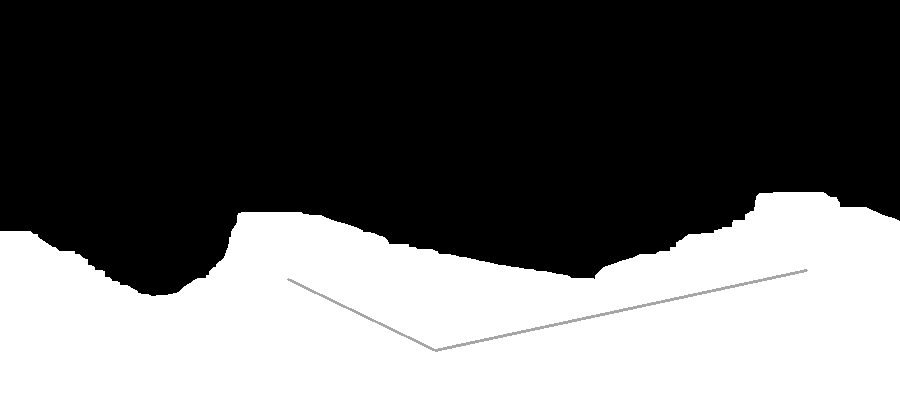

In [ ]:
#V
imageV=fgmask  
color = (	166, 46, 68) 
thickness = 2 
#1.  53, 337,408,351 ,350,450
start_point = (y[0], x[0])  
end_point = (y[2],x[2]) 
imageV = cv2.line(imageV, start_point, end_point, color, thickness) 
#2

start_point1 = (y[1],x[1])  
end_point1 = (y[2],x[2])  
imageV = cv2.line(imageV, start_point1, end_point1, color, thickness) 
cv2_imshow(imageV)

In [ ]:
#récuperer les valeurs de i et j dans la matrice des pixels blancs
listjaune=0
listnoir=0
jaune,noir=calcul_couverture(imageV,listjaune,listnoir)  
        
    
print('nb pixels blancs =',jaune)
print('nb pixels noirs =',noir)
nb=0
for i in range(0,imageV.shape[0]-1):
  for j in range(0,imageV.shape[1]-1):
     if imageV[i,j]==166:
       nb=nb+1
print('nb pixels des lignes dessinées en gris =',nb)

nb pixels blancs = 1335
nb pixels noirs = 0
nb pixels des lignes dessinées en gris = 1529


#affichage

In [ ]:

affImage =cv2.resize(im, (200, 200), interpolation= cv2.INTER_AREA)
affRoute= cv2.resize(affRoute, (200, 200), interpolation= cv2.INTER_AREA)
affSquelette= cv2.resize(affSquelette, (200, 200), interpolation= cv2.INTER_AREA)
affSquelettetraitement= cv2.resize(affSquelettetraitement, (200, 200), interpolation= cv2.INTER_AREA)


Text(0.5, 1.01, 'Type')

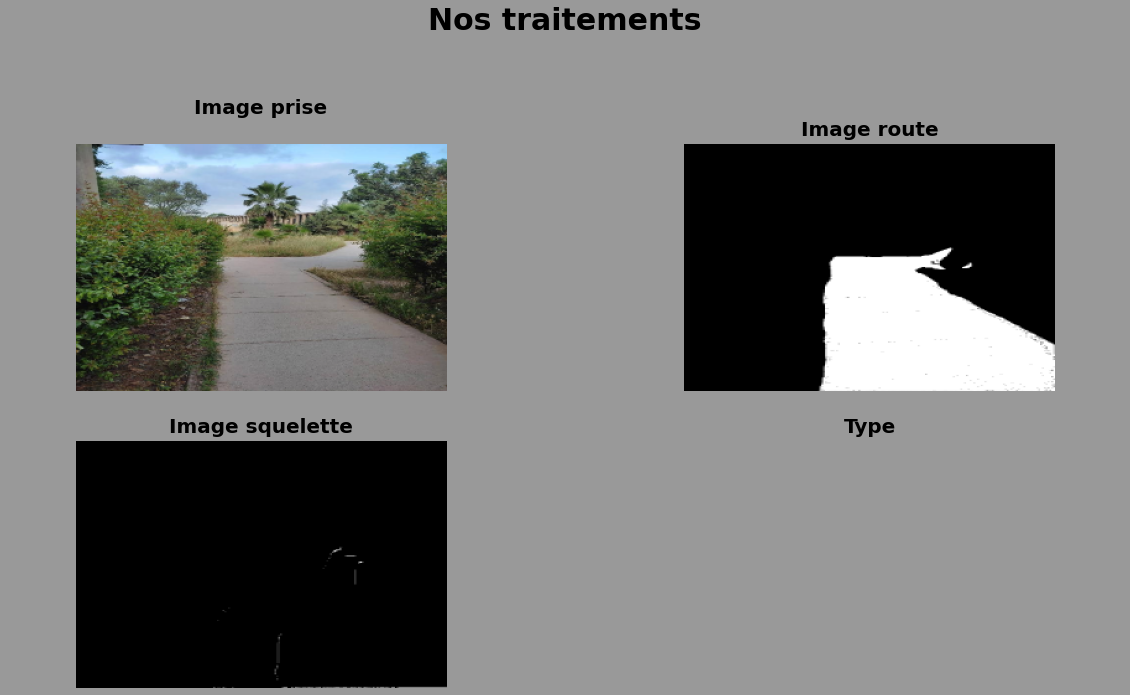

In [ ]:
# code for displaying multiple images in one figure

#import libraries
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor( 'black')
fig.patch.set_alpha( 0.4)



# setting values to rows and column variables
rows = 2
columns = 2

# reading images
affImage =cv2.resize(im, (300, 200), interpolation= cv2.INTER_AREA)
affRoute= cv2.resize(affRoute, (300, 200), interpolation= cv2.INTER_AREA)
affSquelette= cv2.resize(affSquelette, (300, 200), interpolation= cv2.INTER_AREA)

plt.title("Nos traitements",fontsize = 30, x = 0.5, y = 1.2,fontweight = 'bold',family = 'sans-serif')
plt.axis('off')
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(cv2.cvtColor(affImage, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Image prise",fontsize = 20, x = 0.5, y = 1.1,fontweight = 'bold',family = 'sans-serif')

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(cv2.cvtColor(affRoute, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Image route",fontsize = 20, x = 0.5, y = 1.01,fontweight = 'bold',family = 'sans-serif')

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
plt.imshow(cv2.cvtColor(affSquelette, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Image squelette",fontsize = 20, x = 0.5, y = 1.01,fontweight = 'bold',family = 'sans-serif')



# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 4)

# showing image

plt.axis('off')
plt.title("Type",fontsize = 20, x = 0.5, y = 1.01,fontweight = 'bold',family = 'sans-serif')
